(tensor-network-optimization)=

# Optimization

In [20]:
import quimb as qu
import quimb.tensor as qtn

In [21]:
L = 64
D = 16
pbc = True

psi = qtn.MPS_rand_state(L, bond_dim=D, cyclic=pbc)
ham = qtn.MPO_ham_heis(L, cyclic=pbc)

In [22]:
def norm_fn(psi):
    nfact = (psi.H @ psi)**0.5
    return psi.multiply(1 / nfact, spread_over='all')


def loss_fn(psi, ham):
    b, h, k = qtn.tensor_network_align(psi.H, ham, psi)
    energy_tn = b | h | k
    return energy_tn ^ ...


In [23]:
tnopt = qtn.TNOptimizer(
    # the tensor network we want to optimize
    psi,
    # the functions specfying the loss and normalization
    loss_fn=loss_fn,
    norm_fn=norm_fn,
    # we specify constants so that the arguments can be converted
    # to the  desired autodiff backend automatically
    loss_constants={"ham": ham},
    # the underlying algorithm to use for the optimization
    # 'l-bfgs-b' is the default and often good for fast initial progress
    optimizer="adam",
    autodiff_backend="jax",
)
tnopt

<TNOptimizer(d=32768, backend=jax)>

In [24]:
tnopt.optimize(1000)

-28.294601440430 [best: -28.294666290283] : : 1001it [00:38, 26.15it/s]                        


<MatrixProductState(tensors=64, indices=128, L=64, max_bond=16)>

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='Iteration', ylabel='Loss'>)

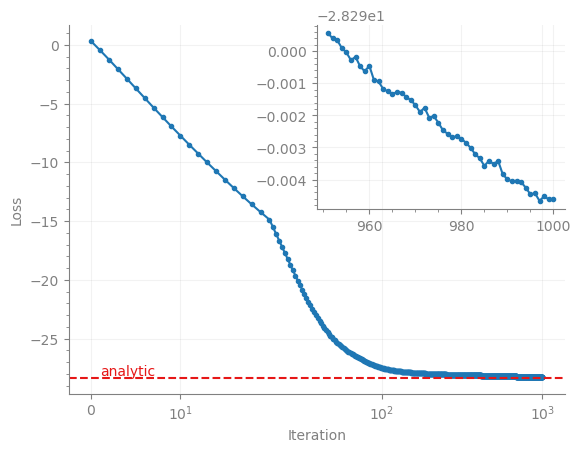

In [25]:
tnopt.plot(hlines={'analytic': qu.heisenberg_energy(L)})

## Using tags to opt in, opt out or group tensors

In [26]:
for site in psi.sites:
    t = psi[site]
    if site % 2 == 0:
        t.add_tag("A")
        t.modify(data=psi[0].data)
    else:
        t.add_tag("B")
        t.modify(data=psi[1].data)

psi.normalize()
psi.equalize_norms_()

<MatrixProductState(tensors=64, indices=128, L=64, max_bond=16)>

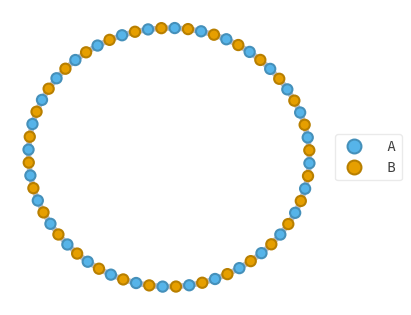

In [27]:
psi.draw(["A", "B"], figsize=(4, 4))

In [28]:
tnopt = qtn.TNOptimizer(
    psi,
    loss_fn=loss_fn,
    norm_fn=norm_fn,
    loss_constants={"ham": ham},
    optimizer="adam",
    autodiff_backend="jax",
    # only optimize the tensors with these tags (in this case all)
    tags=["A", "B"],
    # within those, group all with each of these tags together
    shared_tags=["A", "B"],
)
tnopt

<TNOptimizer(d=1024, backend=jax)>

In [29]:
tnopt.optimize(1000)

-28.304227828979 [best: -28.304290771484] : : 1001it [00:28, 35.30it/s]                        


<MatrixProductState(tensors=64, indices=128, L=64, max_bond=16)>

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='Iteration', ylabel='Loss'>)

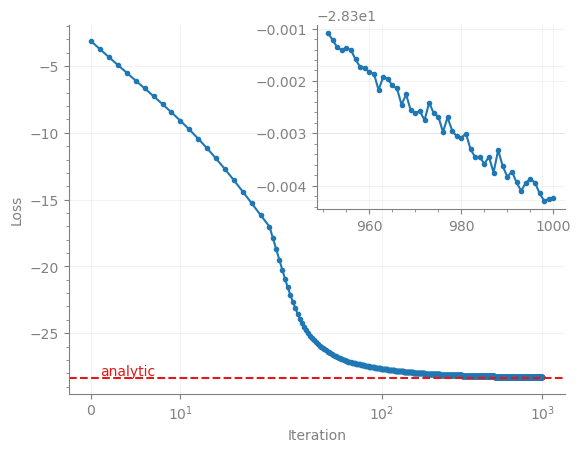

In [30]:
tnopt.plot(hlines={'analytic': qu.heisenberg_energy(L)})

In [31]:
psi_opt = tnopt.get_tn_opt()

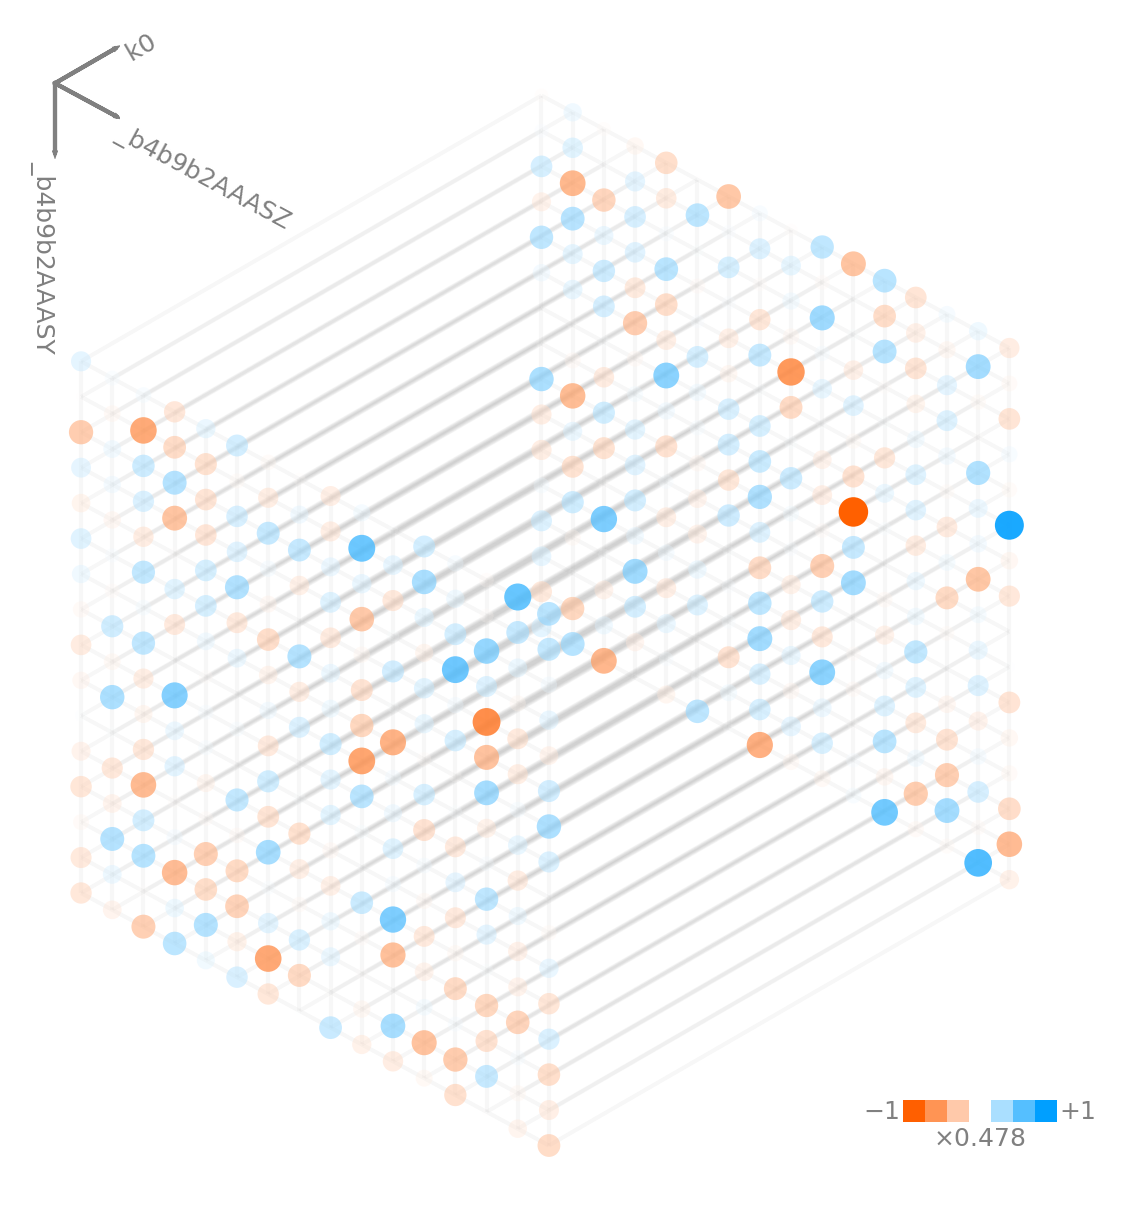

In [32]:
psi_opt[0].visualize(legend=True)[0]

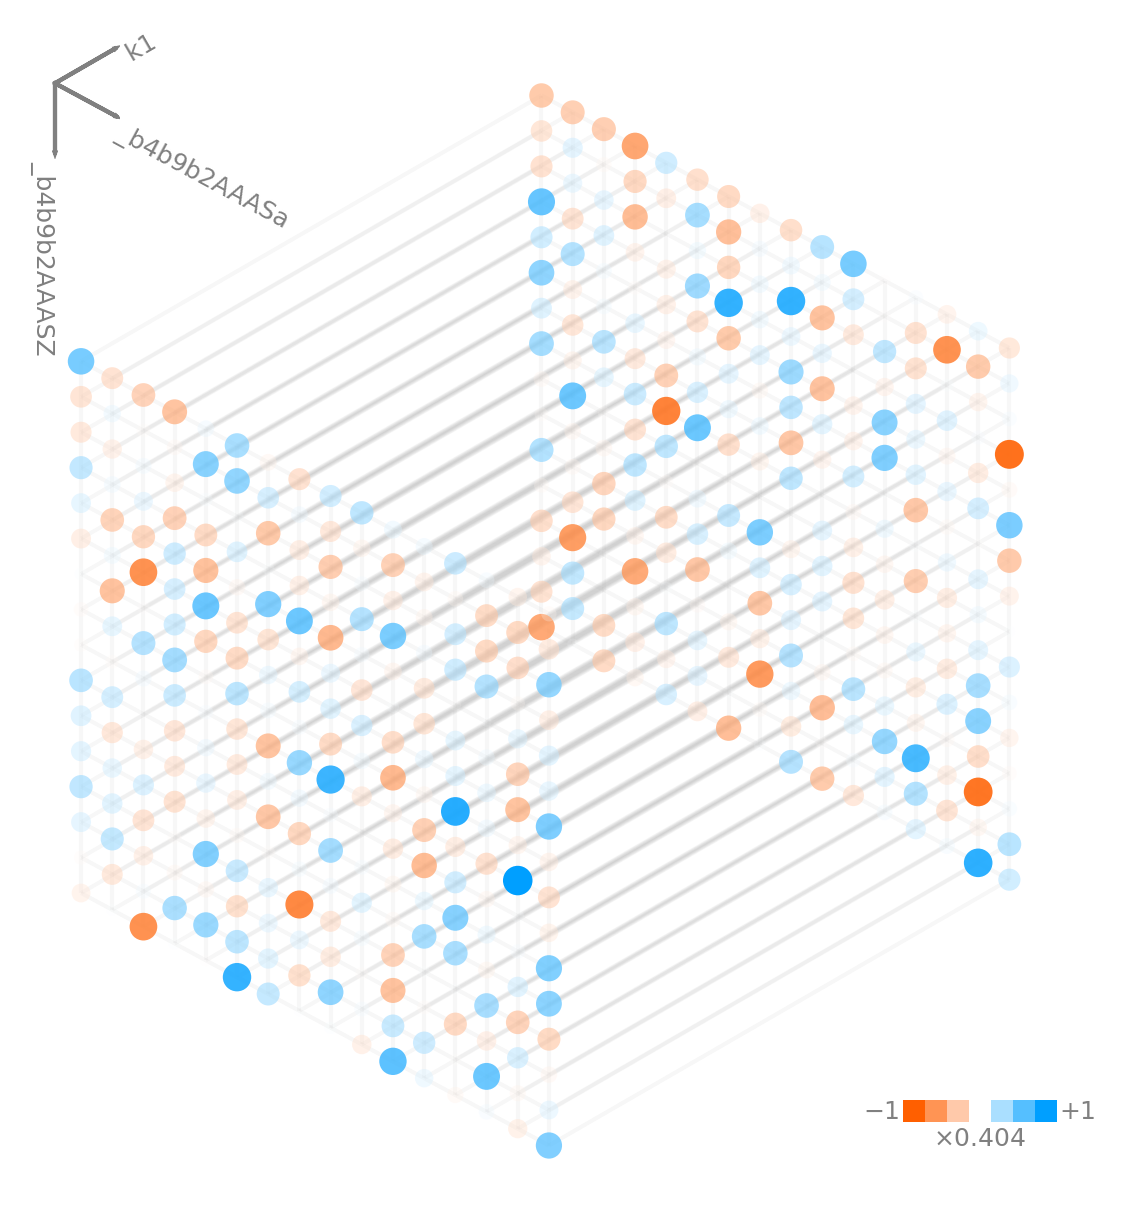

In [33]:
psi_opt[1].visualize(legend=True)[0]

In [34]:
loss_fn(psi_opt, ham)

-28.30422033705775